In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
from itertools import combinations
import pytensor.tensor as pt
from pytensor.tensor.variable import TensorVariable

# 7. Coagulation*

An example of Bayesian ANOVA.

Adapted from [Unit 7: anovacoagulation.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/anovacoagulation.odc).

Here 24 animals are randomly allocated to 4 different diets,  but the numbers allocated to different diets are not the same. The coagulation time for blood is measured for each animal. Are the diet-based differences significant? Example from page 166 of [Statistics for Experimenters](https://pages.stat.wisc.edu/~yxu/Teaching/16%20spring%20Stat602/%5bGeorge_E._P._Box,_J._Stuart_Hunter,_William_G._Hu(BookZZ.org).pdf) {cite:t}`box2005statistics`.

In [2]:
# cut and pasted data from .odc file
# fmt: off
times = (62, 60, 63, 59, 63, 67, 71, 64, 65, 66, 68, 66, 71, 67, 68, 68, 56, 62,
         60, 61, 63, 64, 63, 59)
diets = (1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4)
# fmt: on

# create dictionary where each key is a diet and values are lists of times
data = {}
for key, val in zip(diets, times):
    data.setdefault(key, []).append(val)
data

{1: [62, 60, 63, 59],
 2: [63, 67, 71, 64, 65, 66],
 3: [68, 66, 71, 67, 68, 68],
 4: [56, 62, 60, 61, 63, 64, 63, 59]}

## Simple method

Conceptually, this is the simplest method to set up this model and look at the contrasts, but it's not very concise. It would be inefficient to type out all this code every time, especially if there were more groups.

In [3]:
with pm.Model() as m0:
    mu0 = pm.Normal("mu_0", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alpha = pm.ZeroSumNormal("alpha", sigma=10, shape=4)

    mu_1 = mu0 + alpha[0]
    mu_2 = mu0 + alpha[1]
    mu_3 = mu0 + alpha[2]
    mu_4 = mu0 + alpha[3]

    pm.Normal("lik1", mu=mu_1, tau=tau, observed=data[1])
    pm.Normal("lik2", mu=mu_2, tau=tau, observed=data[2])
    pm.Normal("lik3", mu=mu_3, tau=tau, observed=data[3])
    pm.Normal("lik4", mu=mu_4, tau=tau, observed=data[4])

    onetwo = pm.Deterministic("α1-α2", alpha[0] - alpha[1])
    onethree = pm.Deterministic("α1-α3", alpha[0] - alpha[2])
    onefour = pm.Deterministic("α1-α4", alpha[0] - alpha[3])
    twothree = pm.Deterministic("α2-α3", alpha[1] - alpha[2])
    twofour = pm.Deterministic("α2-α4", alpha[1] - alpha[3])
    threefour = pm.Deterministic("α3-α4", alpha[2] - alpha[3])

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau, alpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [4]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_0,64.001,0.523,63.034,65.003
tau,0.179,0.057,0.079,0.284
alpha[0],-2.955,1.021,-4.934,-1.104
alpha[1],1.980,0.878,0.313,3.634
alpha[2],3.954,0.895,2.245,5.608
alpha[3],-2.979,0.800,-4.520,-1.491
α1-α2,-4.935,1.597,-7.996,-1.997
α1-α3,-6.909,1.608,-9.875,-3.832
α1-α4,0.025,1.511,-2.750,2.953
α2-α3,-1.974,1.436,-4.607,0.820


Text(0.5, 1.0, 'Ridgeplot of $\\alpha$ and contrasts')

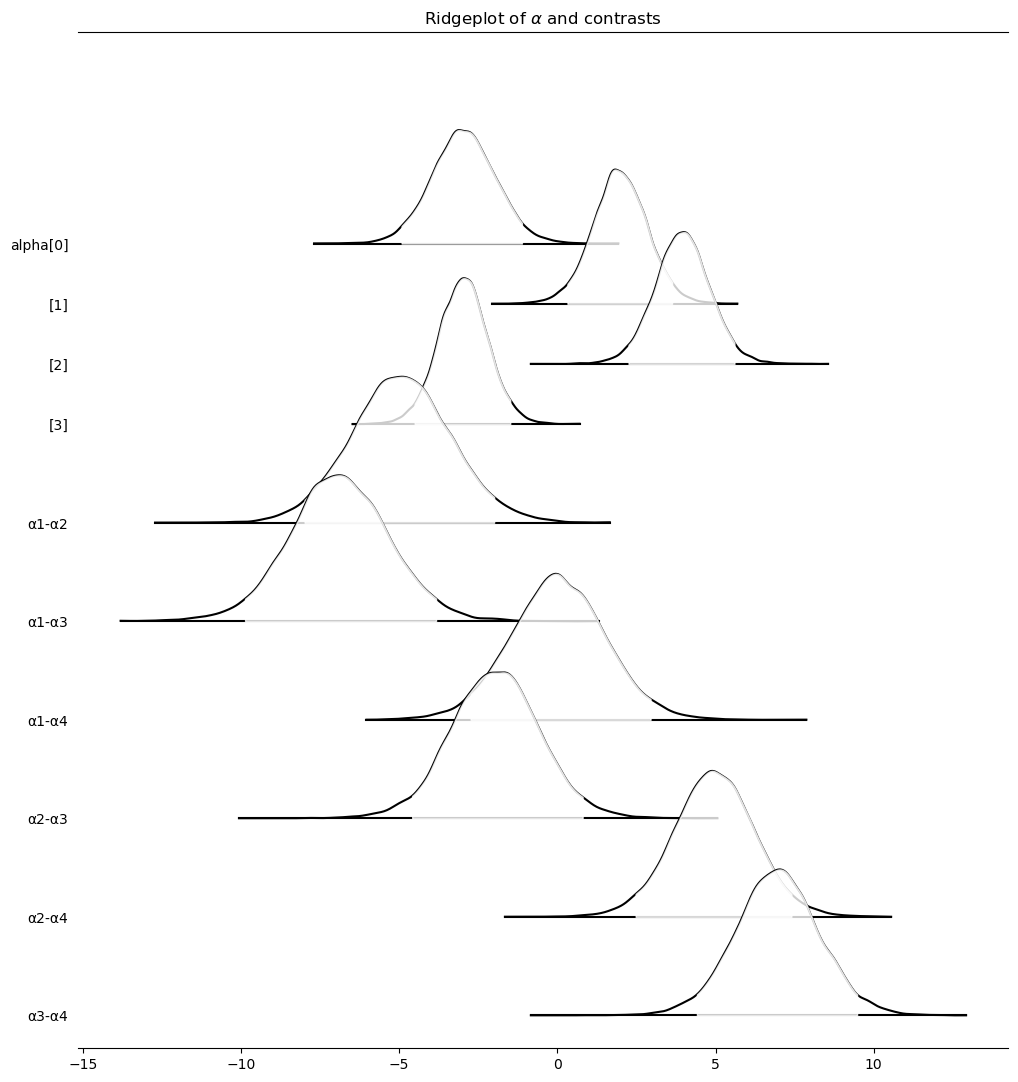

In [5]:
axes = az.plot_forest(
    trace,
    var_names=["~mu_0", "~tau"],
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=False,
    ridgeplot_overlap=2,
    ridgeplot_alpha=0.8,
    colors="white",
)

axes[0].set_title("Ridgeplot of $\\alpha$ and contrasts")

Another downside to this method is how ```pm.model_to_graphviz``` comes out.

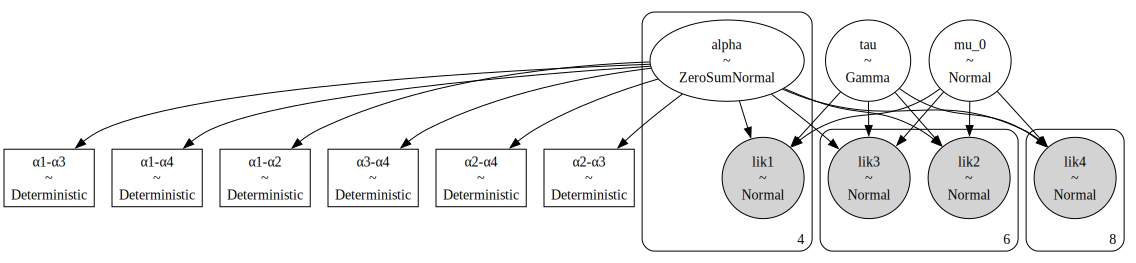

In [6]:
pm.model_to_graphviz(m0)

## More concise methods

We've been meaning to update this part for quite a while. Recently, one of our excellent students, Nhan Quach, helped us out. The rest of the page is their work. Both of these methods are completely equivalent to the above. They just approach the problem from different perspectives. You can pick which one makes the most sense to you.

Huge thanks to Nhan for updating this!

In [7]:
# switching to a Pandas Dataframe for these models
data = pd.DataFrame(zip(diets, times), columns=["diets", "times"])
diets_idx, diet = pd.factorize(data["diets"])

### Method 1

The first method is based on how each pair-wise contrast can be written out as a series of equations:

$$
\begin{align*} \alpha_1 - \alpha_2 + 0\alpha_3 + \dots + 0\alpha_k \\  \alpha_1 + 0\alpha_2 -\alpha_3 + \dots + 0\alpha_k \\  \dots \\ \alpha_1 + 0\alpha_2 + 0\alpha_3 + \dots - \alpha_k \\ 0\alpha_1 + \alpha_2 - \alpha_3 + \dots + 0\alpha_k \\ \dots \end{align*}
$$

This could be rewritten into a multiplication between a ${k \choose 2} \times k$ matrix and a $k \times 1$ vector as such: 
$$
\begin{bmatrix}
1 & -1 & 0 & 0 & \cdots & 0 \\
1 & 0  & -1 & 0 & \cdots & 0 \\
1 & 0  & 0  & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots
\end{bmatrix}
\times
\begin{bmatrix}
\alpha_1 \\
\alpha_2 \\
\alpha_3 \\
\vdots \\
\alpha_k
\end{bmatrix}
$$

In [8]:
def pairwise_contrasts_v1(
    groups: int,
    group_labels: list[str] | None = None,
    parameter_label: str = "⍺",
) -> tuple[np.typing.NDArray[np.int_], list[str]]:
    """Builds out a matrix of which pair-wise differences to perform along with names to assign each contrast"""
    names = []
    num_pairs = (groups * (groups - 1)) // 2
    matrix = np.zeros((num_pairs, groups))
    for pair_idx, (g1, g2) in enumerate(combinations(range(groups), 2)):
        matrix[pair_idx, g1], matrix[pair_idx, g2] = 1, -1
        if group_labels is not None:
            names.append(
                f"{parameter_label}[{group_labels[g1]}] - {parameter_label}[{group_labels[g2]}]"
            )
    return matrix, names


pairwise_contrast_matrix, contrast_labels = pairwise_contrasts_v1(
    4, diet, "αlpha"
)

with pm.Model(coords={"diets": diet, "contrast_labels": contrast_labels}) as m1:
    mu0 = pm.Normal("mu[0]", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alphas = pm.ZeroSumNormal("αlpha", sigma=10, dims="diets")
    mus = mu0 + alphas
    # Index each mus similar to how is done in the Simvastatin Example
    pm.Normal("Likelihood", mu=mus[diets_idx], tau=tau, observed=data["times"])
    pm.Deterministic(
        "Contrast",
        pm.math.dot(pairwise_contrast_matrix, alphas),
        dims="contrast_labels",
    )
    trace = pm.sample(5000)

az.summary(trace, kind="stats")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu[0], tau, αlpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%
mu[0],64.007,0.521,63.060,65.034
tau,0.178,0.057,0.078,0.285
αlpha[1],-2.942,1.026,-4.910,-1.056
αlpha[2],1.974,0.883,0.232,3.579
αlpha[3],3.951,0.888,2.232,5.578
αlpha[4],-2.983,0.820,-4.512,-1.427
Contrast[αlpha[1] - αlpha[2]],-4.916,1.601,-7.969,-1.978
Contrast[αlpha[1] - αlpha[3]],-6.893,1.605,-9.947,-3.891
Contrast[αlpha[1] - αlpha[4]],0.040,1.538,-2.807,2.957
Contrast[αlpha[2] - αlpha[3]],-1.977,1.433,-4.833,0.600


## Method 2

The second method takes advantage of NumPy's broadcasting so that we can take a 1-dimensional array of $\alpha = [\alpha_1, \alpha_2, \alpha_3, \dots, \alpha_k]$ and broadcast it into a 2-dimensional $k \times 1$ array called $A$.

Doing $A - \alpha$ would yield the following results

$$
\begin{array}{c|ccccc}
A \backslash \alpha 
    & \alpha_1 
    & \alpha_2 
    & \alpha_3 
    & \cdots 
    & \alpha_k \\ \hline
\alpha_1 
    & 0 
    & \alpha_1 - \alpha_2 
    & \alpha_1 - \alpha_3 
    & \cdots 
    & \alpha_1 - \alpha_k \\
\alpha_2 
    & \alpha_2 - \alpha_1 
    & 0 
    & \alpha_2 - \alpha_3 
    & \cdots 
    & \alpha_2 - \alpha_k \\
\alpha_3 
    & \alpha_3 - \alpha_1 
    & \alpha_3 - \alpha_2 
    & 0 
    & \cdots 
    & \alpha_3 - \alpha_k \\
\vdots 
    & \vdots 
    & \vdots 
    & \vdots 
    & \ddots 
    & \vdots \\
\alpha_k 
    & \alpha_k - \alpha_1 
    & \alpha_k - \alpha_2 
    & \alpha_k - \alpha_3 
    & \cdots 
    & 0
\end{array}
$$

Only the upper triangle is needed offset by the first diagonal (since the first diagonal would be all 0s). NumPy and Pytensor both support the ability of pulling out the first upper triangle.

In [9]:
def pairwise_contrasts_v2(tensor: TensorVariable):
    """Returns the array of pair-wise differences"""
    differences = tensor[:, None] - tensor
    upper_tri = pt.triu_indices_from(differences, k=1)
    return differences[upper_tri]


contrast_labels = [
    f"alpha[{c1}] - alpha[{c2}]" for c1, c2 in combinations(diet, 2)
]

with pm.Model(coords={"diets": diet, "contrast_labels": contrast_labels}) as m2:
    mu0 = pm.Normal("mu[0]", mu=0, tau=0.0001)
    tau = pm.Gamma("tau", 0.001, 0.001)

    alphas = pm.ZeroSumNormal("αlpha", sigma=10, dims="diets")
    mus = mu0 + alphas
    # Index each mus similar to how is done in the Simvastatin Example
    pm.Normal("Likelihood", mu=mus[diets_idx], tau=tau, observed=data["times"])
    pm.Deterministic(
        "Contrast", pairwise_contrasts_v2(alphas), dims="contrast_labels"
    )
    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu[0], tau, αlpha]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


In [10]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu[0],64.001,0.522,63.023,64.996
tau,0.179,0.057,0.082,0.290
αlpha[1],-2.961,1.015,-4.838,-1.029
αlpha[2],1.974,0.892,0.283,3.653
αlpha[3],3.971,0.885,2.318,5.639
αlpha[4],-2.984,0.816,-4.471,-1.376
Contrast[alpha[1] - alpha[2]],-4.935,1.599,-8.029,-1.963
Contrast[alpha[1] - alpha[3]],-6.932,1.588,-9.984,-4.020
Contrast[alpha[1] - alpha[4]],0.023,1.523,-2.723,2.996
Contrast[alpha[2] - alpha[3]],-1.997,1.443,-4.723,0.670


Both of these methods make nicer model diagrams as well as seen below from the pm.model_to_graphviz output.

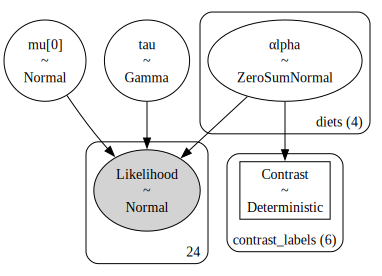

In [11]:
pm.model_to_graphviz(m1)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Tue Nov 25 2025

Python implementation: CPython
Python version       : 3.13.8
IPython version      : 9.6.0

pytensor: 2.28.3

pandas  : 2.3.3
arviz   : 0.22.0
numpy   : 2.3.3
pymc    : 5.21.1
pytensor: 2.28.3

